# MODELS OF INFLUENCE & DIFFUSION 

This notebook will explain about the implementation of Information difusion models by using Network Difussion Librar(NDlib). NDlib is a Python language software package for the describing, simulate, and study diffusion processes on complex networks.

It is built upon the NetworkX python library and is intended to provide:
* A tools for the study diffusion dynamics on social, biological, and infrastructure networks,
* A standard programming interface and diffusion models implementation that is suitable for many applications,
* A a rapid development environment for collaborative, multidisciplinary, projects.
The documentation of this library is available on https://ndlib.readthedocs.io/en/latest/overview.html

In [401]:
#import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
from random import randint
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from bokeh.io import output_notebook, show
from ndlib.viz.mpl.PrevalenceComparison import DiffusionPrevalenceComparison
#from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.MultiPlot import MultiPlot
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison

##  Information Diffusion Models

In this section we will implement two popular basic model using NDlib which is a python libraries for the describing, simulate, and study diffusion processes on complex networks


1. Linear Threshold Model(LT): 
It defines a threshold-based behavior, where the influence accumulates from multiple neighbors of the node, which becomes activated only if the cumulative influence passed a certain threshold. In our problem, this behaviour might eventually convince some facebook users to adopt the new product after hearing a lot about if from their freinds.

2. Independent Cascade model(IC):
In this model the active neighbors has a probabilistic and independent chance to activate the node. This resembles a viral virus spread, such as in Covid-19, where each of the social interactions might trigger the infection.


### Linear Threshold (LT)
The model works as follows; each node has its own threshold; during a generic iteration every node is observed: if the percentage of its infected neighbors is greater than its threshold it becomes infected as well. 

During the simulation a node can have one among the two statuses code; O means Susceptible and 1 means infected

In [419]:
def linear_threshold(g,s):
    # Model selection
    model = ep.ThresholdModel(g)
    
    # Model Configuration
    config = mc.Configuration()
    
    # Setting node parameters
    config.add_model_initial_configuration("Infected", s)
    threshold = 0.1
    for i in g.nodes():
        config.add_node_configuration("threshold", i, threshold)

    model.set_initial_status(config)

    # Simulation execution
    iterations = model.iteration_bunch(10)   
    #md="Linear Threshold"
    trends = model.build_trends(iterations)
    return model,trends,iterations

### Independent Cascade (IC)
This model starts with an initial set of active nodes A0, the diffusive process work as follows:
1. When node v becomes active in step t, it is given a single chance to activate each currently inactive neighbor w; it succeeds with a probability p(v,w).
2. If w has multiple newly activated neighbors, their attempts are sequenced in an arbitrary order.
3. If v succeeds, then w will become active in step t + 1; but whether or not v succeeds, it cannot make any further attempts to activate w in subsequent rounds.
4. The process runs until no more activations are possible.

During the simulation a node can have one among the three statuses code; 0 means Susceptible and 1 means infected and 2 means removed


In [420]:
def independent_cascade(g,s):
    # Model selection
    model = ep.IndependentCascadesModel(g)
    
    # Model Configuration
    config = mc.Configuration()
    
    # Setting node parameters
    config.add_model_initial_configuration("Infected", s)
    threshold = 0.1
    for i in g.nodes():
        config.add_node_configuration("threshold", i, threshold)

    model.set_initial_status(config)

    # Simulation execution
    iterations = model.iteration_bunch(10)
    trends = model.build_trends(iterations)
    #md="Independent Cascade(IC)"
    return model,trends,iterations

### Choosing The Initial Infected Nodes
To start the process of information diffusion we need to choose the Initial infected nodes that will help to propagate the information to all other nodes in a network. In NDlib, both model(LT,IC) the initial infection status can be defined in two ways:

* fraction_infected: Model Parameter, float in [0, 1], this set the initial set of infected nodes as 1% of the overall population, and assign a threshold of 0.1 to all the edges as a default values in not given.To set the initial infected node add this line in model configuration

      config.add_model_parameter('fraction_infected', 0.1)

* Infected: Status Parameter, set of nodes, you can choose some of the node in your datasets randomly, or by using some metrics such as degree centrality, betweeness centrality, closeness centrality. Choosing between these measures depend on the nature of your datasets and the problem you want to solve. To set initial nodes in your model add the follwoing line in node parameters setting, where s represent the list of selected node.

      config.add_model_initial_configuration("Infected", s)

### Helper functions
This section we will implement some helpful functions that will help us to the process. 

In [399]:
#finding initial infected nodes
def initial_infected_node(measure,no_nodes):
    return list(dict(sorted(measure.items(), key=lambda item: item[1],reverse=True)).keys())[:no_nodes]

In [386]:
# compare the performance of each model in information difussion
def model_comparison(g,s):
    model_ic,trends_ic,iterations_ic=independent_cascade(g,s)
    model2_lt,trends_lt,iterations_lt=linear_threshold(g,s)
    # Visualization
    viz = DiffusionTrendComparison([model_ic, model2_lt], [trends_ic, trends_lt])
    #viz.plot("trend_comparison.pdf")
    p= viz.plot()
    return p

In [445]:
#get the total infected number of each model
def getting_infected_node(d):
    
    #length of dictionary
    n=len(d)
    list_node=[]
    for i in range(n):
        for key,value in d[i]['status'].items():
            if(value==1):
                list_node.append(key)
    count= len(list_node)       
    return count

In [387]:
#get the infected node by each iteration
def getting_infected_node(d):
    data = {'iteration':[],'infected_nodes': []}
    n=len(d)
    
    for i in range(1,n):
        infected_nodes=[]

        for key,value in d[i]['status'].items():
            if value == 1:
                infected_nodes.append(key)
        data['iteration'].append(i)
        data['infected_nodes'].append(len(infected_nodes))
            

    df = pd.DataFrame(data,index=None)       
    return df

In [394]:
def draw_graph(g):
    pos = nx.spring_layout(g, seed=200)
    options = {
    "node_color": "blue",
    "node_size": 20,
    "edge_color": "grey",
    "linewidths": 0,
    "width": 0.1,
    }
    nx.draw(g, pos, **options)
    return plt.show()

###  Data Analysis on Facebook users
This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app. The dataset includes node features (profiles), circles, and ego networks.
We will use a facebook datasest available on http://snap.stanford.edu/data/ego-Facebook.html 

#### About the datasests 

In [395]:
#read the datasets
facebook = pd.read_csv(
    "facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)

In [396]:
#creating the graph
G = nx.from_pandas_edgelist(facebook,  source='start_node',target='end_node',create_using=nx.DiGraph())

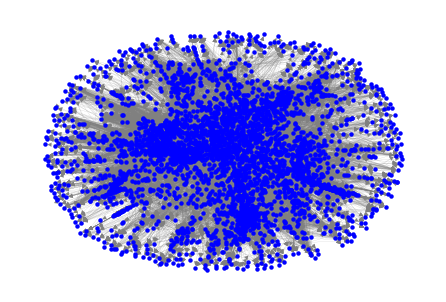

In [397]:
#visualising the graph
#draw_graph(G)

In [398]:
print("Number of nodes: ",G.number_of_nodes())
print("Number of edges: ",G.number_of_edges())

Number of nodes:  4039
Number of edges:  88234


### Analysing the Information Difussion
In this section we will analyse the perfomance of each model in the process of propagating the infomation. To fit our graph to the model we have implemented we neeed to choose the Initial infected nodes, the are facebook users that will act as influencer toward information propagation.The following are the methods we will use to find the influencer:
* Randomly
* Degree Centrality
* Closeness Centrality
* Betweeness Centrality

#### Choosing Infected Node by Randomly
Here we will randomly choose a potion of nodes in a graph as the Initial infected nodes, we will use 

In [428]:
S_randomly = rd.sample(G.nodes, 400)

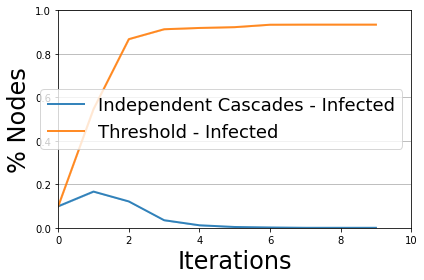

In [430]:
model_comparison(G,S_randomly)

##### Result:
The results show that the LH perfom better compared to IC, we can not directly conclude about the percantage of infected nodes computed with respect to the number of iterations, because the source node are computed randomly. And everytime we compute we will get different results. But the intuition here is that the IC model does not fit to propagate the information if the node are computed randomly and each one is given a single chance to infect others.

#### Choosing The Source Node by  Degree Centrality
Degree Centrality is measured as the number of direct links that involve a given node. Here we will focus more in out_degree centrality,to find a list of 20 facebook users with the highest centrality.
* Why out_degreee centrality?

A node with highest out_degree centrality is able to reach many people in the network and will be able to propagate the information very fast.

In [438]:
S_out_degree = initial_infected_node(nx.out_degree_centrality(G),20)

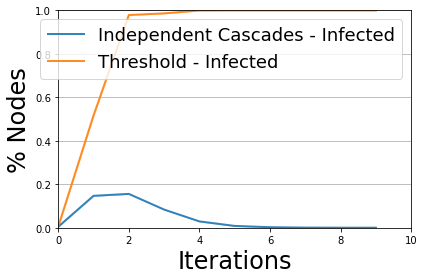

In [439]:
model_comparison(G,S_out_degree)

##### Result 
Threshold model infect help to diffuse the information very fast and in 2nd iteration it was able to infect approximately 100% of all the facebook users in a network. The Independent cascade model propagate the information of 10% users from the whole network and in 6th iteration the diffusion process stop. 

#### Choosing The Source Node by Closeness Centrality
Is the shortest path between a node and all other reacheable nodes. It measure of how long it will take for information to spread from given node to other nodes in the network. Here we want to select the facebook user with the highest closeness centrality among all the connected node.


In [440]:
S_closeness = initial_infected_node(nx.closeness_centrality(G),20)

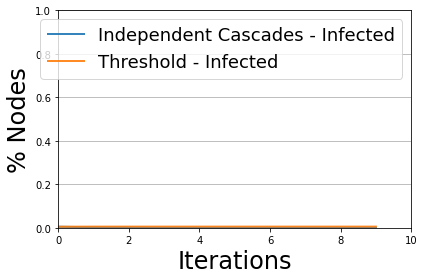

In [441]:
model_comparison(G,S_closeness)

##### Results
In this case we can say that the closeness centrality does not have any impact to the diffusion ofinformation according to the nature of our datasets.

#### Choosing The Source Node by  Betweeness Centrality
Betweenness centrality measures the extent to which a node plays this bridging role in a network. Specifically, betweenness centrality measures the extent that the user falls on the shortest path between other pairs of users in the network. The more people depend on a user to make connections with other people, the higher that user's betweenness centrality becomes.

In [442]:
S_betweeness = initial_infected_node(nx.betweenness_centrality(G),20)

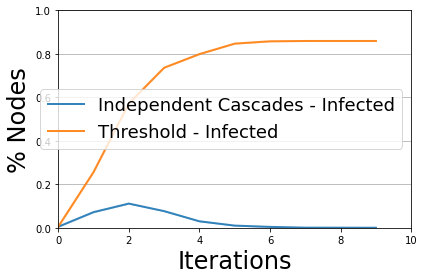

In [443]:
model_comparison(G,S_betweeness)

##### Results
The results show that Threshold model is perfoming better compared to Independent cascade. TH model stop to propagate the information in the 5th iteration and approximately 85% of the facebook users were infected.

### Comparing the perfomance of the Model with different metrices
In this section we will compare the results of each model with respect to all the measures we have discuss in the previous sections.

In [ ]:
total_infected={}

#random
getting_infected_node(d)

### Conclusion